# Sporulation

In [4]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7f5c96a130f0>

In [3]:
with open('../../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

### Essentiality of FS genes

In [4]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [5]:
from bacillusme.analysis import sensitivity as ss

In [6]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for g in sporeme.metabolites.query(re.compile('RNA_BSU.*_s$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_FS_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):   9%|▉         | 9/100 [1:21:18<3:06:30, 122.97s/it]   

In [ ]:
flux_responses = {}
f = 'essentiality_raw_results_naive_FS'
for i in os.listdir():
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

In [ ]:
df = flux_responses.T
repeat = []
for i,row in df.drop('base').iterrows():
    f = row['translation_'+i]
    if  f>0.:
        repeat.append(i)
repeat

### Essentiality of MC genes

In [4]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [8]:
from bacillusme.analysis import sensitivity as ss

In [6]:
genes = ['BSU' + g.id.split('RNA_BSU')[1] for \
         g in sporeme.metabolites.query(re.compile('RNA_BSU.*[^s]$'))]

In [ ]:
for i in range(0,int(len(genes)/100)+1):
    a,b = (i*100,i*100 + 100)
    b = min(b,len(genes))
    print(i+1,a,b)
    flux_responses = ss.all_flux_responses(sporeme,genes[a:b],NP=10,precision=1e-6, solution=sporeme.solution,
                       single_change_function='gene_knockout',growth_key='sigma')
    flux_responses.to_csv('essentiality_raw_results_naive_MC_{}.csv'.format(i+1))

1 0 100


biomass_dilution_s response (10 threads):  27%|██▋       | 27/100 [6:05:35<32:52:40, 1621.37s/it]

In [704]:
flux_responses = {}
f = 'essentiality_raw_results_naive_MC'
for i in os.listdir():
    if f not in i: continue
    if f+'.csv' == i: continue
    d = pd.read_csv(i,index_col=0).to_dict()
    for k,v in d.items():
        flux_responses[k] = v
flux_responses = pd.DataFrame.from_dict(flux_responses)
flux_responses.to_csv('{}.csv'.format(f))

essentiality_raw_results_naive_MC.csv


### Gene interdependence

In [5]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [511]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [2]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS.csv',index_col=0).T
VG_df = pd.read_csv('essentiality_raw_results.csv',index_col=0).T

In [513]:
cutoff = 1e-16
translation = df[df['biomass_dilution']>cutoff][[i for i in df.columns if re.search('translation_.*_s',i)]].T
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [514]:
essential_genes = list(df[df['biomass_dilution']<cutoff].index)
VG_essential_genes = list(VG_df[VG_df['biomass_dilution']<cutoff].index)
active_genes = [g.split('translation_')[1].split('_s')[0] for g in active_base.columns]

In [515]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('translation_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### Known depletions

In [548]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]

In [549]:
res = {}
for g in known_depletions:
    locus = name_to_locus[g]
    dep_genes = [i for i in id_dep[locus]]
    res[g] = {
        'locus_id':locus,
        'in_model':'RNA_'+locus in sporeme.metabolites,
        'FS_essential':locus in essential_genes,
        'VG_essential':locus in VG_essential_genes,
        'active':locus in active_genes,
        'depends on':', '.join([locus_to_name[i] if i in locus_to_name else i for i in dep_genes])
    }

In [543]:
res_df = pd.DataFrame.from_dict(res).T.sort_index()

In [544]:
res_df.to_csv('proteomics/dependence_results.csv')

In [545]:
res_df.sort_values('depends on',ascending=False).head(20)

,locus_id,in_model,FS_essential,VG_essential,active,depends on
ilvC,BSU28290,True,False,True,True,"sufU, ilvD, ilvC"
ilvB,BSU28310,True,False,False,True,"sufU, ilvD, era, ilvC, ilvB, ilvH"
citB,BSU18000,True,False,False,True,"sufU, citB, icd"
sucD,BSU16100,True,False,False,True,"sucD, sucC"
sucC,BSU16090,True,False,False,True,"sucD, sucC"
pdhD,BSU14610,True,False,False,True,"pdhD, nadD, odhA, odhB, era, maeS"
samT,BSU11010,True,False,True,True,"metA, trxA, sat, cysH, yvrB, metE, metI, hom, sucD, sucC, samT"
metE,BSU13180,True,False,True,True,"metA, trxA, sat, cysH, yvrB, metE, metI, hom, sucD, sucC, samT"
metI,BSU11870,True,False,True,True,"metA, trxA, sat, cysH, metI, hom, sucD, sucC"
sat,BSU15590,True,False,True,True,"metA, trxA, sat, cysH, metI, hom"


In [547]:
# None of them are essential
res_df['FS_essential'].value_counts()

False    89
Name: FS_essential, dtype: int64

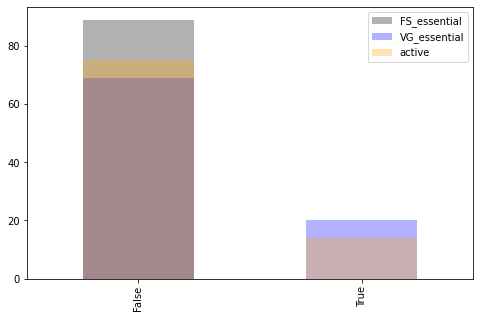

In [522]:
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/gene_interdependence_stats.svg',format='SVG')

In [523]:
res_df['active'].value_counts()

False    75
True     14
Name: active, dtype: int64

In [524]:
res_df[res_df['active']==True]

,locus_id,in_model,FS_essential,VG_essential,active,depends on
acdA,BSU37170,True,False,False,True,"fadA, fadN, acdA, era"
citB,BSU18000,True,False,False,True,"sufU, citB, icd"
fadN,BSU32840,True,False,False,True,"fadA, fadN"
ilvB,BSU28310,True,False,False,True,"sufU, ilvD, era, ilvC, ilvB, ilvH"
ilvC,BSU28290,True,False,True,True,"sufU, ilvD, ilvC"
metE,BSU13180,True,False,True,True,"metA, trxA, sat, cysH, yvrB, metE, metI, hom, sucD, sucC, samT"
metI,BSU11870,True,False,True,True,"metA, trxA, sat, cysH, metI, hom, sucD, sucC"
pdhD,BSU14610,True,False,False,True,"pdhD, nadD, odhA, odhB, era, maeS"
samT,BSU11010,True,False,True,True,"metA, trxA, sat, cysH, yvrB, metE, metI, hom, sucD, sucC, samT"
sat,BSU15590,True,False,True,True,"metA, trxA, sat, cysH, metI, hom"


In [525]:
df.loc[['base','BSU11010_s','BSU13180_s']][['translation_BSU13180_s','translation_BSU11010_s']]

,translation_BSU13180_s,translation_BSU11010_s
base,1.514271e-09,5.039778e-10
BSU11010_s,0.000000e+00,0.000000e+00
BSU13180_s,0.000000e+00,0.000000e+00


13


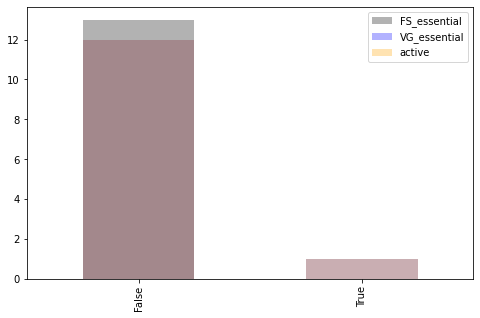

In [526]:
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']
print(len(confirmed_depletions))
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df.loc[confirmed_depletions]['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df.loc[confirmed_depletions]['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df.loc[confirmed_depletions]['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/confirmed_gene_interdependence_stats.svg',format='SVG')

In [588]:
df = res_df.loc[confirmed_depletions]
df[df['in_model']==False].shape[0]

5

In [589]:
res_df[res_df['in_model']==False].shape[0]

30

## Backward interdependence

In [528]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

In [529]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

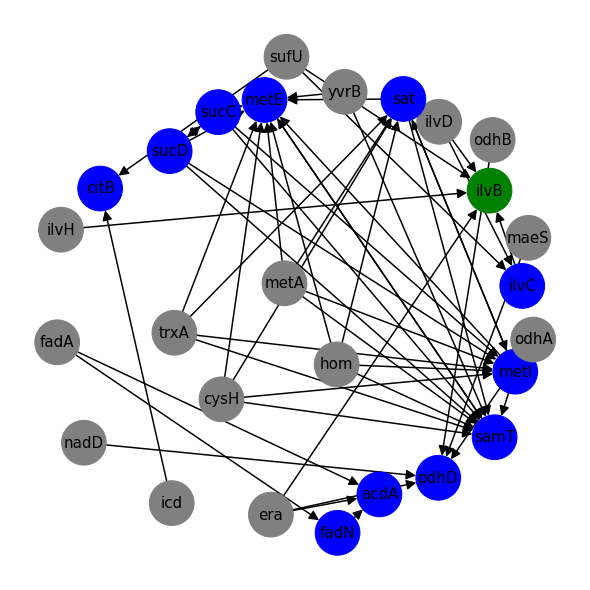

In [530]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
       node_size=2000,
       arrowsize=20,
       width = 1.5,
       font_size=15,
       node_color=color_map)
plt.savefig('./figures/network_gene_interdependence_spring.svg',format='SVG')

## Forward interdependence

In [584]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [585]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

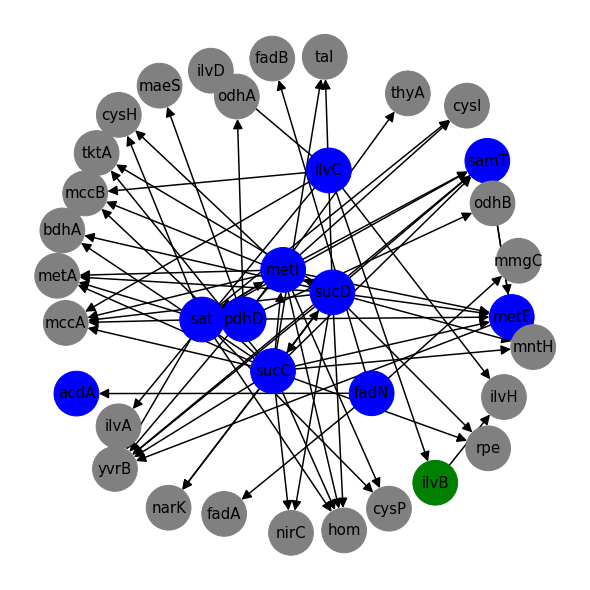

In [586]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
       node_size=2000,
       arrowsize=20,
       width = 1.5,
       font_size=15,
       node_color=color_map)
plt.savefig('./figures/network_gene_interdependence_spring_fwd.svg',format='SVG')

## FWD and BWD interdependence

In [580]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [581]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

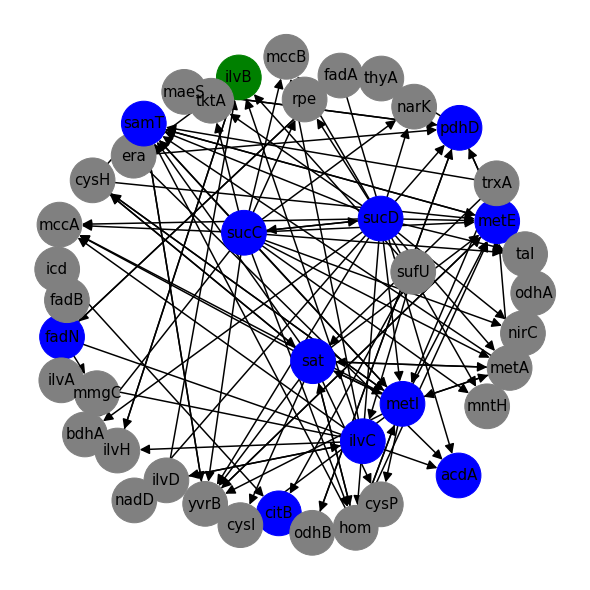

In [583]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
       node_size=2000,
       arrowsize=20,
       width = 1.5,
       font_size=15,
       node_color=color_map)
plt.savefig('./figures/network_gene_interdependence_spring_fwd_bwd.svg',format='SVG')

## Genome-scale interdependence

In [534]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in sporeme.genes:
    i = i.id
    dep_genes = fwd_id_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [535]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_id_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 10:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

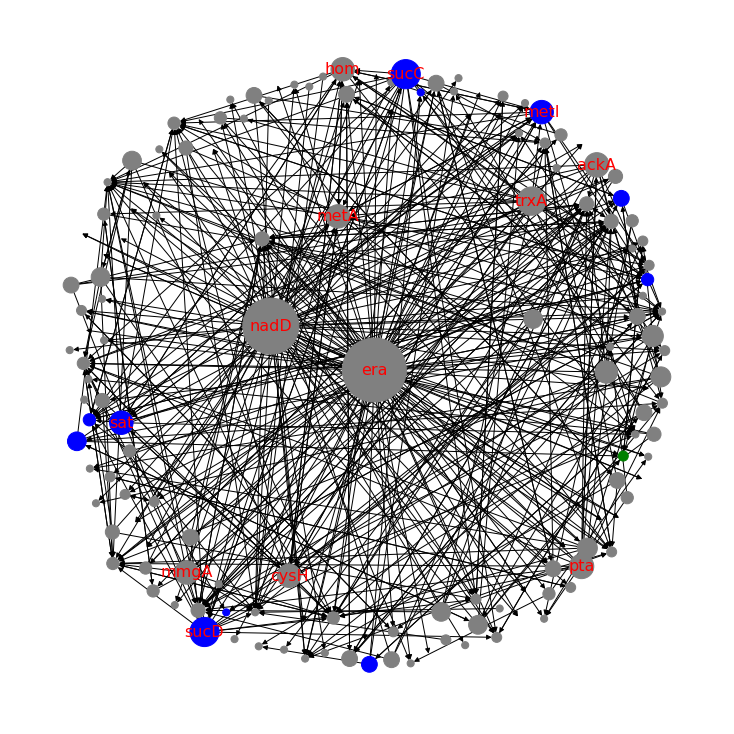

In [536]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='r')
plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

### Heatmap

In [590]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [592]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]

In [655]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_naive_FS.csv',index_col=0).T
translation = df[[i for i in df.columns if re.search('translation_.*_s',i)]].T
translation = translation[translation['base']>cutoff].T.drop('base')

In [657]:
from tqdm import tqdm
import seaborn as sns

In [674]:
expression = {}
for i,row in tqdm(translation.iterrows()):
    i = i.split('_s')[0]
    iname = locus_to_name[i] if i in locus_to_name else i
    expression[iname] = {}
    for j,val in row.items():
        j = j.split('translation_')[1].split('_s')[0]
        jname = locus_to_name[j] if j in locus_to_name else j
        expression[iname][jname] = val
expression = pd.DataFrame.from_dict(expression).drop('dummy')

964it [00:00, 1374.60it/s]


In [678]:
depletions_in_model = [i for i in known_depletions if i in expression.index]

In [690]:
log_expression_all = np.log10(expression[depletions_in_model]+1e-16)
log_expression_known = np.log10(expression.loc[depletions_in_model][depletions_in_model]+1e-16)

<AxesSubplot:>

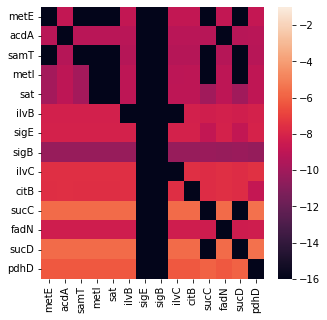

In [693]:
plt.figure(figsize=(5,5))
sns.heatmap(log_expression_known,
           vmin = -1,
           vmax = -16)

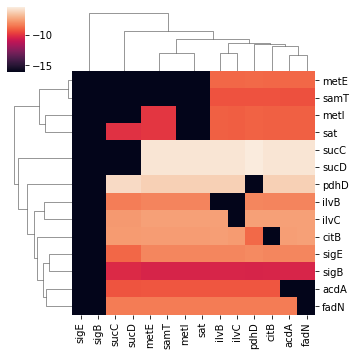

In [695]:
sns.clustermap(log_expression_known,
              figsize=(5,5))

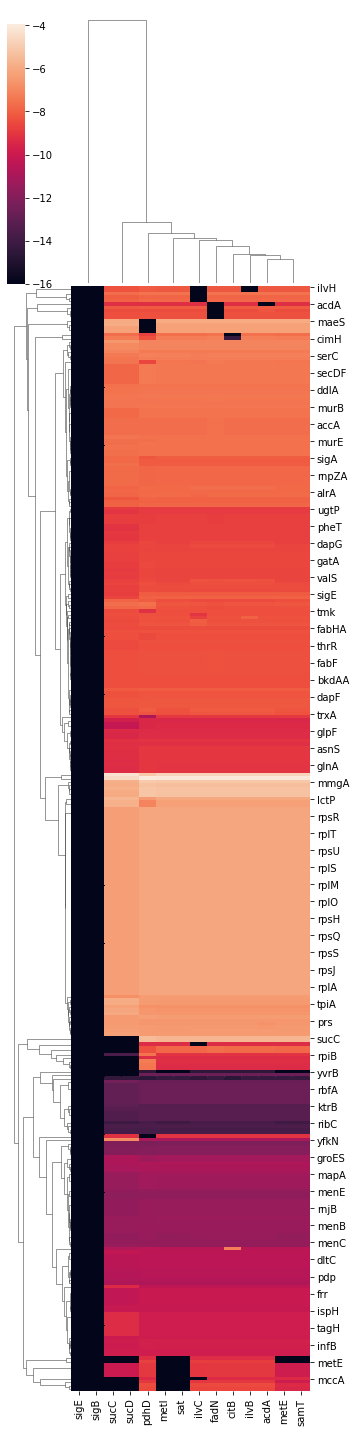

In [698]:
sns.clustermap(log_expression_all,
              figsize=(5,20))